# Data: Ad Sales Data
# Use Case: Revenue Prediction
# Model: Regression Models

Code link: https://www.kaggle.com/code/akshaysunil07/ad-tech-revenue-regression/notebook 

# Installing packages section

In [ ]:
# Installing packages set for without init script
!pip install --upgrade pip

!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 fosforio fosforml numpy pandas matplotlib scikit-learn xgboost python-dateutil 
#!pip install tqdm 
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15
!pip install seaborn

# Restart and clear outputs

# Importing packages

In [1]:
from fosforio import snowflake
from fosforml import *
from fosforml.constants import MLModelFlavours
from fosforio import get_dataframe

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
import seaborn as sns

import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
#from tqdm import tqdm
import time
import calendar
import configparser
from dateutil.relativedelta import relativedelta
import datetime

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from time import sleep
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.


/tmp/pip_packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Matplotlib created a temporary cache directory at /tmp/matplotlib-jacd9m38 because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Importing data from snowflake

In [2]:
#from fosforio import snowflake
#from fosforio import get_dataframe
snowflake.get_connection(connection_name="ME_AD_SALES_CXN")
df = get_dataframe("AD_SALES_IMP")
df_all = get_dataframe("AD_TECH_INPUT")

Connection object created: <snowflake.connector.connection.SnowflakeConnection object at 0x7f83b864c250>
Please close the connection after use!
Reading dataframe from snowflake native connector
Reading dataframe from snowflake native connector


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     567291 non-null  object 
 1   site_id                  567291 non-null  int16  
 2   ad_type_id               567291 non-null  int8   
 3   geo_id                   567291 non-null  int16  
 4   device_category_id       567291 non-null  int8   
 5   advertiser_id            567291 non-null  int16  
 6   order_id                 567291 non-null  int16  
 7   line_item_type_id        567291 non-null  int8   
 8   os_id                    567291 non-null  int8   
 9   integration_type_id      567291 non-null  int8   
 10  monetization_channel_id  567291 non-null  int8   
 11  ad_unit_id               567291 non-null  int16  
 12  total_impressions        567291 non-null  int16  
 13  total_revenue            567291 non-null  float64
 14  view

In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ad_date                  567291 non-null  object 
 1   site_id                  567291 non-null  int16  
 2   ad_type_id               567291 non-null  int8   
 3   geo_id                   567291 non-null  int16  
 4   device_category_id       567291 non-null  int8   
 5   advertiser_id            567291 non-null  int16  
 6   order_id                 567291 non-null  int16  
 7   line_item_type_id        567291 non-null  int8   
 8   os_id                    567291 non-null  int8   
 9   monetization_channel_id  567291 non-null  int8   
 10  ad_unit_id               567291 non-null  int16  
 11  total_impressions        567291 non-null  int16  
 12  total_revenue            567291 non-null  float64
 13  viewable_impressions     567291 non-null  int16  
 14  meas

In [3]:
df.columns = df.columns.str.lower()
df_all.columns = df_all.columns.str.lower()
#df.info()

In [7]:
df_all.columns

Index(['ad_date', 'site_id', 'ad_type_id', 'geo_id', 'device_category_id',
       'advertiser_id', 'order_id', 'line_item_type_id', 'os_id',
       'monetization_channel_id', 'ad_unit_id', 'total_impressions',
       'total_revenue', 'viewable_impressions', 'measurable_impressions',
       'revenue_share_percent', 'ad_type', 'ad_format', 'ad_media_type',
       'device_type', 'city', 'city_code', 'population', 'city_lat',
       'city_lon', 'line_item_group', 'line_item_type', 'monetization_channel',
       'os_type'],
      dtype='object')

# Exploratory data analysis

In [12]:
cat_col=['ad_date', 'site_id','advertiser_id', 'order_id','ad_type', 'ad_format', 'ad_media_type',
         'device_type', 'city', 'line_item_group', 'line_item_type', 'monetization_channel','os_type']
scat_col = ['site_id','ad_type', 'ad_format', 'device_type', 'advertiser_id',
            'line_item_group', 'line_item_type', 'os_type','monetization_channel']
num_col=list(df_all.select_dtypes(np.number).columns)

In [ ]:
fig, ax = plt.subplots(4,2, figsize=(14,12))
axes_ = [axes_row for axes in ax for axes_row in axes]

for i,col in enumerate(scat_col):
    sns.countplot(data=df_all,x=col,ax=axes_[i])
    if col=='advertiser_id':
        plt.xticks(rotation=90)
    plt.tight_layout()

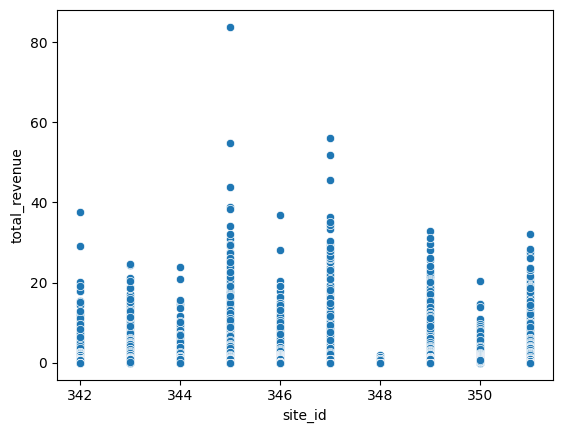

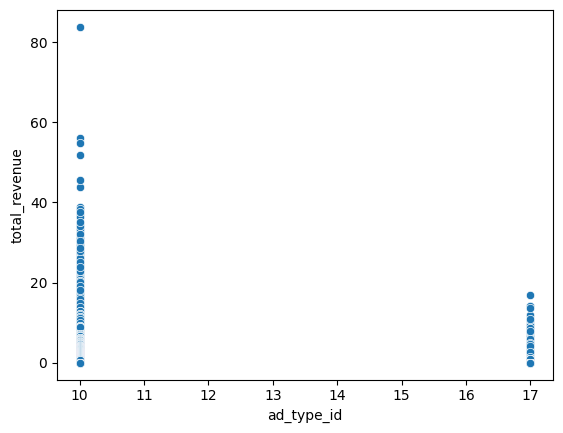

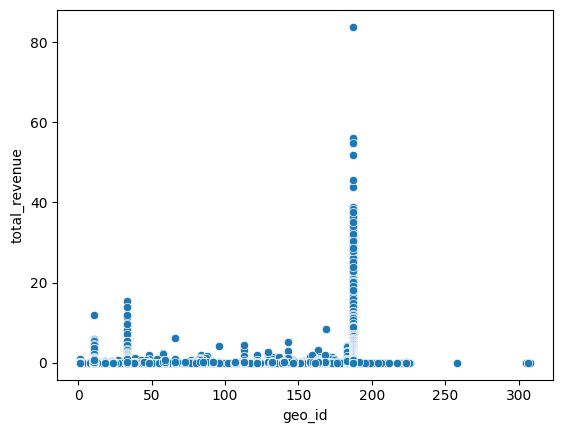

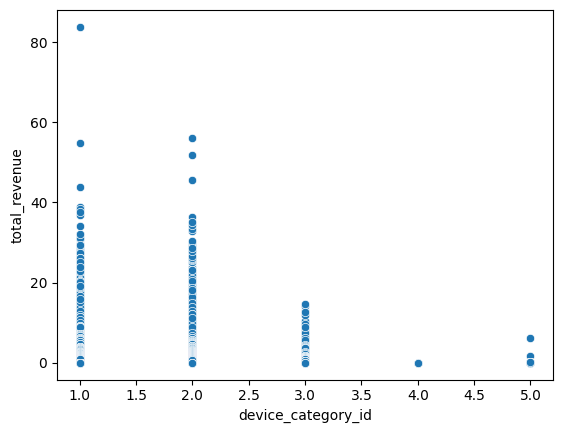

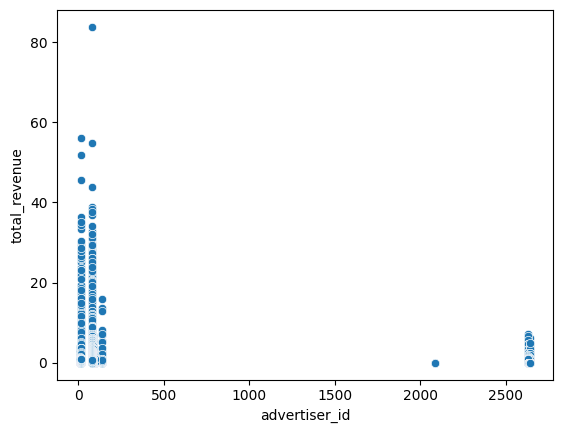

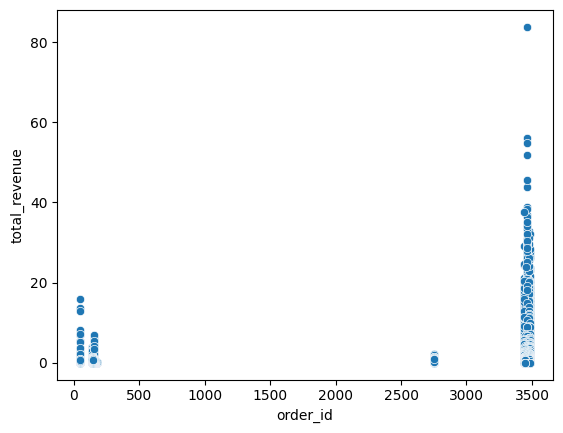

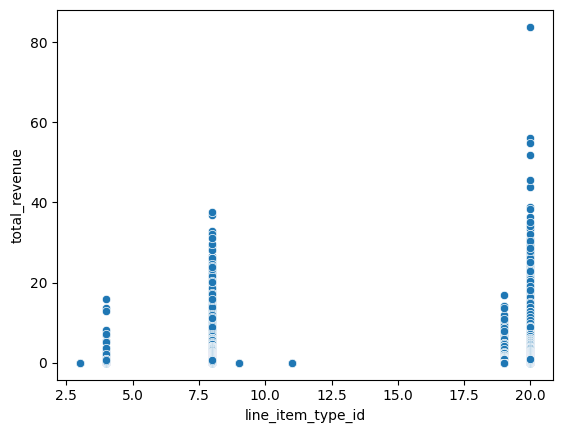

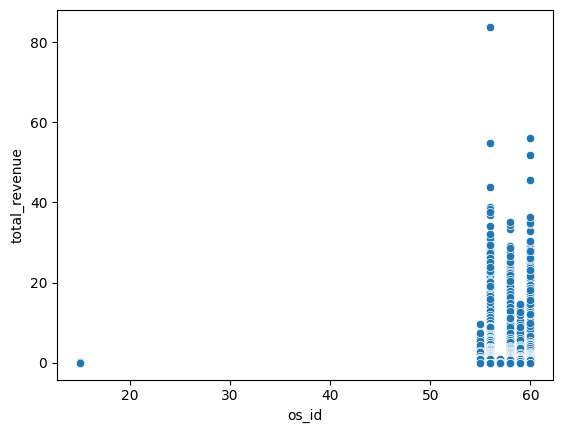

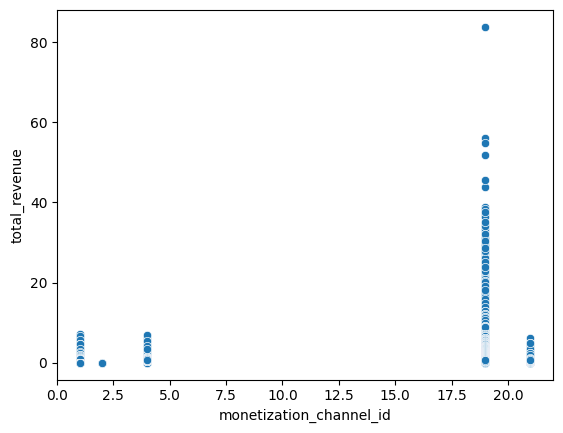

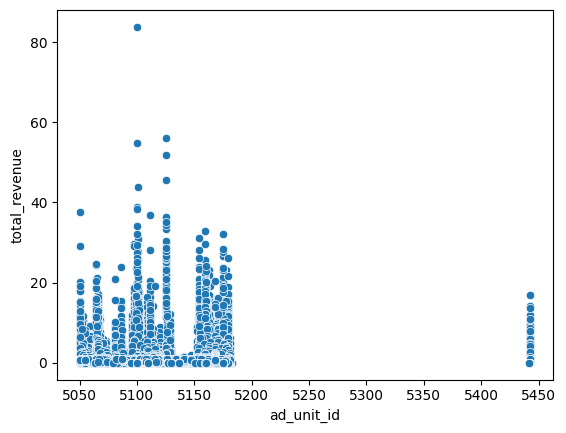

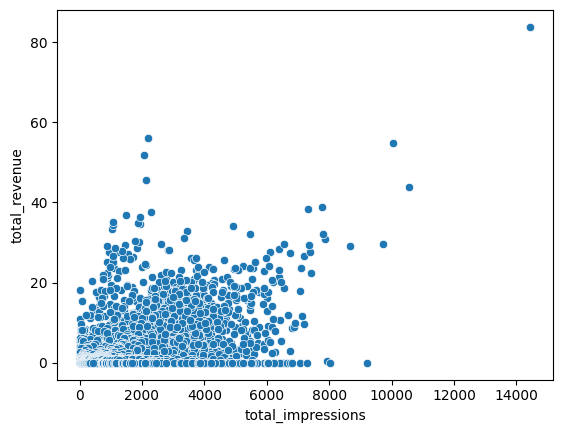

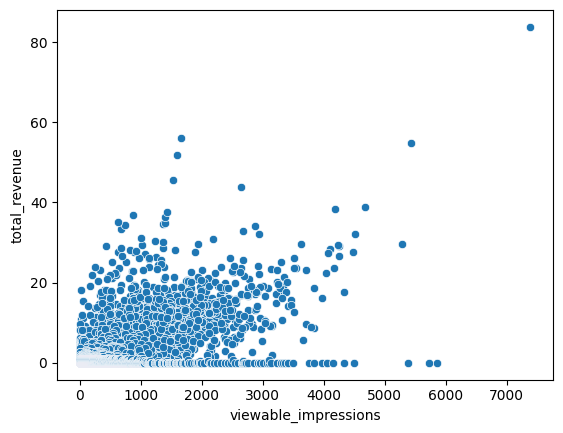

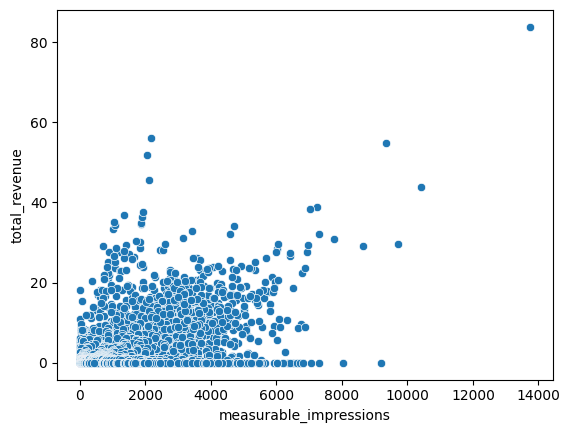

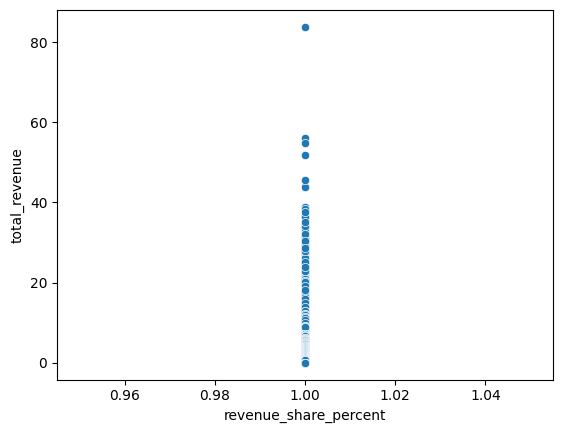

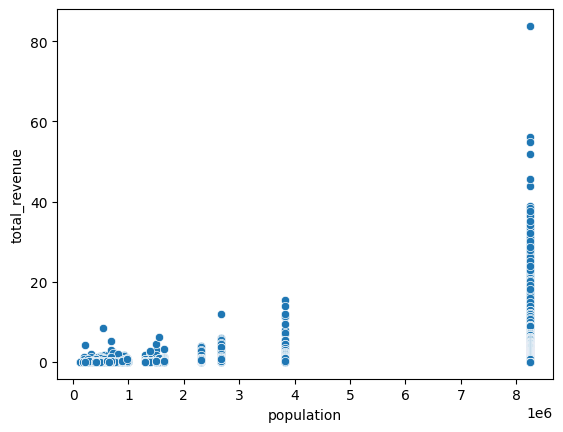

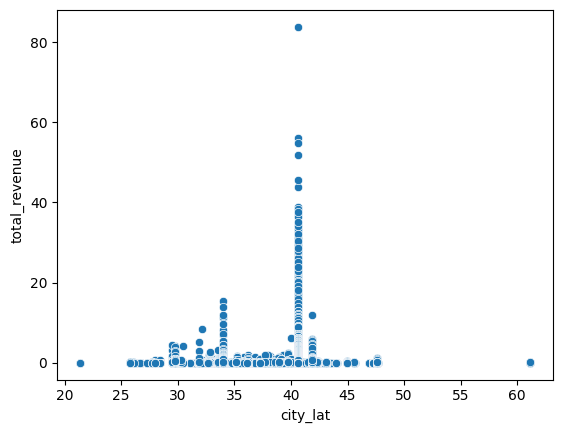

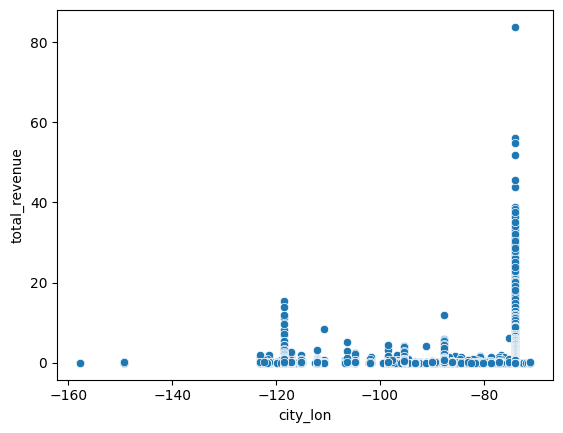

In [11]:
for i in num_col:
    if i!='total_revenue':
        sns.scatterplot(data=df_all,x=i,y='total_revenue')
        plt.show()

In [ ]:
#df.max()

In [ ]:
for col in (scat_col):
    title='Relationship of '+col+' with total_revenue'
    plt.figure(figsize=(6,4))
    sns.barplot(y=df['total_revenue'],x=df[col])
    if col=='advertiser_id':
        plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

In [ ]:
for col in (scat_col):
    title='Relationship of '+ col +' with total_impressions'
    plt.figure(figsize=(6,4))
    sns.barplot(y=df['total_impressions'],x=df[col],)
    if col=='advertiser_id':
        plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

In [ ]:
for i in cat_col:
    df[i]=df[i].astype('object')

In [ ]:
#df.info()

In [ ]:
df.drop(['ad_unit_id','revenue_share_percent','integration_type_id','ad_type_id','site_id','advertiser_id',
        'date','geo_id','order_id'],axis=1,inplace=True)
#df.select_dtypes(object)

In [ ]:
for i in df.select_dtypes(object).columns:
    pd.crosstab(df['monetization_channel_id'],df[i]).plot(kind='bar')
    plt.show()

# Predictive Modelling

In [ ]:
#df.info()

In [ ]:
import joblib

In [ ]:
Xd = df.drop('total_revenue',axis=1)
y = df['total_revenue']

In [ ]:
Xd.info()

In [ ]:
#df_all.info()

In [ ]:
#X = pd.get_dummies(Xd,drop_first=True)

In [ ]:
#X.info()

In [ ]:
#from sklearn.preprocessing import StandardScaler
#ss = StandardScaler()

In [ ]:
#X[pc_col] = pd.DataFrame(ss.fit_transform(X[pc_col]),columns=[pc_col])

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Xd,y,test_size=0.2,random_state=4)

In [ ]:
pc_col = ['total_impressions', 'viewable_impressions', 'measurable_impressions']

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=2))
        ]), pc_col),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['device_category_id', 'line_item_type_id', 'os_id',
       'monetization_channel_id'])
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [ ]:
models = [

    {
        'name': 'RandomForestRegressor',
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [50],
        'regressor__max_depth': [10],
        'regressor__min_samples_split': [2],
        'regressor__min_samples_leaf': [1],
        'regressor__bootstrap': [True]
    },
]

In [ ]:
#pipeline = Pipeline(steps=[
#    ('preprocessor', preprocessor),
#    ('regressor', LinearRegression())  # Placeholder
#])

best_estimators = []
for model_params in models:
    model_name = model_params.pop('name')  # Extract the model name
    grid_search = GridSearchCV(pipeline, model_params, cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimator = grid_search.best_estimator_
    best_estimators.append(best_estimator)
    print(f"Training completed for model {model_name}")
    
    # Save the best model
    joblib.dump(best_estimator, f'best_model_{model_name}.pkl')
    print(f"Best model {model_name} saved to best_model_{model_name}.pkl")

In [ ]:
best_estimators

In [ ]:
results = []
for estimator in best_estimators:
    y_pred_train = estimator.predict(X_train)
    y_pred_test = estimator.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        'model': estimator.named_steps['regressor'].__class__.__name__,
        'best_params': estimator.named_steps['regressor'].get_params(),
        'mse': mse,
        'r2': r2
    })

results_df = pd.DataFrame(results)
results_df

In [ ]:
y_pred_test.shape

In [ ]:
y_pred_train.shape

# In this section we are joining multiple tables, realigning indexes to get the output

In [ ]:
#check type of data (series/ array/ dataframe)

type(Xd), type(X_train), type(X_test), type(y), type(y_train), type(y_test), type(results), type(y_pred) 

In [ ]:
y_pred

# Creating Data frames as necessary

In [ ]:
y_df= pd.DataFrame(y)
y_df.info()

In [ ]:
y_train_df= pd.DataFrame(y_train)
y_train_df

In [ ]:
y_test_df= pd.DataFrame(y_test)
y_test_df

In [ ]:
index_list_temp = y_train_df.index.values.tolist()
min(index_list_temp), max(index_list_temp), len(index_list_temp)

In [ ]:
index_list_temp = y_test_df.index.values.tolist()
min(index_list_temp), max(index_list_temp), len(index_list_temp)

In [ ]:
y_test_df.info()

In [ ]:
#check type of data (series/ array/ dataframe)

type(X_train), type(X_test), type(y_train_df), type(y_test_df), type(y_pred_train), type(y_pred_test) 

In [ ]:
y_pred_train

In [ ]:
y_train_pred_df = pd.DataFrame(y_pred_train, columns=['predicted_revenue'])

In [ ]:
y_train_pred_df

In [ ]:
y_test_pred_df = pd.DataFrame(y_pred_test,columns=['predicted_revenue'])

In [ ]:
y_train_df.reset_index(drop = True)
y_train_df

In [ ]:
# Joining Actuals and predicted Y columns

y_train_final= pd.concat([y_train_df, y_train_pred_df.set_index(y_train_df.index)], axis=1)
y_train_final

In [ ]:
y_test_final= pd.concat([y_test_df, y_test_pred_df.set_index(y_test_df.index)], axis=1)
y_test_final

In [ ]:
# Joining Train and test Y columns

y_all = pd.concat([y_train_final, y_test_final])

In [ ]:
y_all

In [ ]:
y_compare = pd.merge(y_df, y_all, left_index=True, right_index=True)
y_compare.head()

In [ ]:
y_compare[y_compare['total_revenue_x']!=y_compare['total_revenue_y']].head()

In [ ]:
#y_all = y_all.sort_index(axis=1, inplace = True)

In [ ]:
y_all.sort_index(axis=0, inplace = True)
y_all

In [ ]:
y_all.info()

In [ ]:
df_all

In [ ]:
df_all.info()

In [ ]:
df_final = df_all.sort_index(axis=0)
df_final.head()

In [ ]:
# Joining x and y columns with all details

model_output = pd.merge(df, y_all, left_index=True, right_index=True)
#model_output = pd.concat([df_all, y_all], axis = 1)
#model_output = df_all.join(y_all)
model_output

In [ ]:
#check

print(model_output['predicted_revenue'].sum())
print(model_output['total_revenue_x'].sum())
print(model_output['total_revenue_y'].sum())

In [ ]:
#model_output.columns

In [ ]:
model_output[model_output['total_revenue_x']!=model_output['total_revenue_y']].count()

In [ ]:
# Check if both the columns actually have same values

#model_output['total_revenue'].equals(model_output['total_revenue2']) 
model_output['total_revenue_x'].equals(model_output['total_revenue_y']) 

In [ ]:
model_output['check'] = model_output.apply(lambda x: x['total_revenue_x'] if x['total_revenue_x'] <
                     x['total_revenue_y'] else np.nan, axis=1)

In [ ]:
model_output['check'].unique()

# Pushing Model output to Snowflake

In [ ]:
import os
from snowflake.snowpark.session import Session
user = os.getenv("user")
warehouse = os.getenv("warehouse")
schema= os.getenv("schema")
database = os.getenv("database")
role =  os.getenv("role")
account =  os.getenv("account")
password= os.getenv("password")

connection_params = dict(user=user, 
                         password=password, 
                         account=account, 
                         warehouse=warehouse, 
                         database=database,
                         schema=schema, 
                         role=role)

session = Session.builder.configs(connection_params).create()

session.sql('use warehouse {};'.format(warehouse)).collect()

session.sql('use database {};'.format(database)).collect()

session.sql('use schema {}.{};'.format(database, schema)).collect()

In [ ]:
df_snowflake = session.createDataFrame(model_output.values.tolist(),
        schema = model_output.columns.tolist())

df_snowflake.write.mode("overwrite").save_as_table("ME_DB.ME_AD_SALES_SCHEMA.AD_TECH_OUTPUT")

# Model Registrartion using fosforml SDK

In [ ]:
#Snowpark lib
from snowflake.snowpark import Session

# Data Science Libs
#import numpy as np
#import pandas as pd

# create_temp_table warning suppresion
#import warnings; warnings.simplefilter('ignore')

#ConfigParser to read ini file
# import configparser
#!pip install fosforml
from fosforio import snowflake
from sklearn.pipeline import Pipeline

In [ ]:
from fosforml import *
from fosforml.constants import MLModelFlavours
import requests

In [ ]:
@scoring_func
def score(model, request):
    payload_dict = eval(request.json["payload"])
    df = pd.DataFrame.from_dict(payload_dict)
    
    #handle PCA, one hot and std scaler
    result = model.predict(df)
    #prediction = str(pd.DataFrame({"prediction":result}).to_dict())
    #return prediction
    return result

In [ ]:
payload = X_test.head(100).to_dict()
req = requests.Request()
req.json = {"payload":str(payload)}
y = df
yo = score(pipe, y)
# yo

In [ ]:
payload = X_test.head(1).to_dict()
req = requests.Request()
req.json = {"payload":str(payload)}
y = df
yo = score(pipe, y)

# Sample Payload

In [ ]:
req.json

In [ ]:
yo

In [ ]:
## registering the model in Fosfor.
model_reg = register_model(pipe,
               score, 
               name="Ad Sales Prediction Model", 
               description="Ad_Sales_Prediction_RandomForest_Model",
               flavour=MLModelFlavours.sklearn,
               model_type="regression",
               init_script="\\n pip install fosforml \\n pip install fosforio[snowflake] \\n pip install sklearn\\n pip install snowflake-connector-python[pandas]",
               y_true=y_test,
               y_pred=y_test_pred,
               #prob=y_prob,
               features=X_train.columns,
               input_type="json", 
               explain_ai=True,
               x_train=X_train, 
               x_test=X_test, 
               y_train=y_train,
               y_test=y_test,
               feature_names=X_train.columns.tolist(),
               original_features=X_train.columns.tolist(),
               feature_ids=X_train.columns,
               kyd=True, kyd_score = True)